# Model 14: Social networks

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model14.html

### Note

- Most of the previous models assume unstructured populations (well-mixed population).
    - Exceptions are Model 7 (migration) and Model 11 (cultural group selection), in which agents can only learn from members of their own sub-population,
    - and Model 10 (polarisation) in which agents are in a spatial grid and can only learn from their 4 or 8 neighbours.
- Here we will extend this to explicitly model social networks of agents.
- Social networks specify the exact links between every agent.
    - For example, a friendship network might capture who is friends with who within a group;
    - a kin network might capture who is related to whom in a society;
    - and a citation network might capture which scientists cite which other scientists in their papers.
- Social network analysis originates in sociology, but has become increasingly used in studies of cultural evolution in recent years.

## Adjacency matrices

In [1]:
using Random
using StatsBase
using LinearAlgebra
using Graphs

using Plots
using GraphPlot

In [2]:
g = SimpleGraph(10, 5)
adjacency_matrix(g)

10×10 SparseArrays.SparseMatrixCSC{Int64, Int64} with 10 stored entries:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

## Small world networks

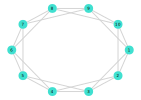

In [3]:
function generate_regular_graph(N::Int, k::Int)::SimpleGraph
    @assert mod(k, 2) == 0 "k must be an even number."

    g = SimpleGraph(N, 0)

    for src in 1:N
        for i in 1:Int(k/2)
            dst = src + i - (src + i > N ? N : 0)
            add_edge!(g, src, dst)
        end
    end

    g
end

function circle_plot(g::SimpleGraph)::Nothing
    display(gplot(g, nodelabel=1:nv(g), layout=circular_layout))
end

N = 10
k = 4
g = generate_regular_graph(N, k)
circle_plot(g)

- With probability $p$ the above network is 'rewired'.
    - We cycle through each node from 1 to $N$.
    - For each one, we take the first neighbour to its right, which given that $k >= 2$ it will be connected to with an edge.
    - Then, with probability $p$, we pick a new_neighbour randomly from the set of all nodes excluding self and nodes to which connections already exist.
    - The existing edge is removed, and a new edge is drawn to the new_neighbour.
    - Remember, this is an undirected network, so every change made from node A to node B needs to be repeated for node B to node A.
    - This keeps the matrix symmetrical.
    - Finally, this whole process is repeated for the next connected neighbour, up to the last, so $k / 2$ times in total.

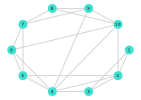

In [4]:
function rewire!(g::SimpleGraph, k::Int, p::Float64)::Nothing
    @assert mod(k, 2) == 0

    for j in 1:Int(k/2)
        for i in 1:N
            if rand() < p
                # pick jth clockwise neighbour
                neighbour = i + j - (i + j > N ? N : 0)

                # pick random new neighbour, excluding self and duplicate edges
                non_neighbors = setdiff(vertices(g), [i; neighbors(g, i)])
                new_neighbor = rand(non_neighbors)

                rem_edge!(g, i, neighbour)
                add_edge!(g, i, new_neighbor)
            end
        end
    end
end

N = 10
k = 4
g = generate_regular_graph(N, k)
p = 0.2
rewire!(g, k, p)
circle_plot(g)

In [5]:
function small_world(N::Int, k::Int, p::Float64)::SimpleGraph
    g = generate_regular_graph(N, k)
    rewire!(g, k, p)
    g
end;

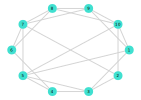

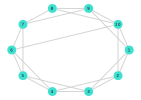

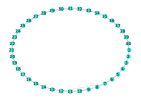

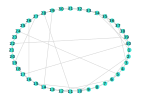

In [6]:
circle_plot(small_world(10, 4, 0.2))
circle_plot(watts_strogatz(10, 4, 0.2))
circle_plot(small_world(40, 4, 0.2))
circle_plot(watts_strogatz(40, 4, 0.2))

## Network properties: Path length and clustering

In [7]:
N = 40
k = 4
g = generate_regular_graph(N, k)

# path length
@show length(a_star(g, 1, 2))
@show length(a_star(g, 1, 12))
@show length(a_star(g, 1, 39))

distance_list = gdistances(g, 1)
distance_list[2], distance_list[12], distance_list[39]

length(a_star(g, 1, 2)) = 1
length(a_star(g, 1, 12)) = 6
length(a_star(g, 1, 39)) = 1


(1, 6, 1)

In [8]:
function average_shortest_path_length(g::SimpleGraph)::Float64
    N = nv(g)
    sum([sum(gdistances(g, i)) for i in 1:N]) / (N * (N - 1))
end

function plot_lines(x, y, ylabel)::Nothing
    p = plot(
        x,
        y,
        xlabel="rewiring probability, p",
        ylabel=ylabel,
        legend=false,
    )
    plot!(x, mean(y, dims=2), lw=4, lc=:black)
    display(p)
end; 

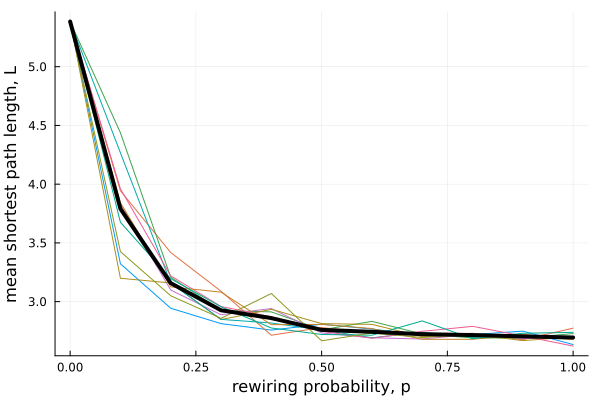

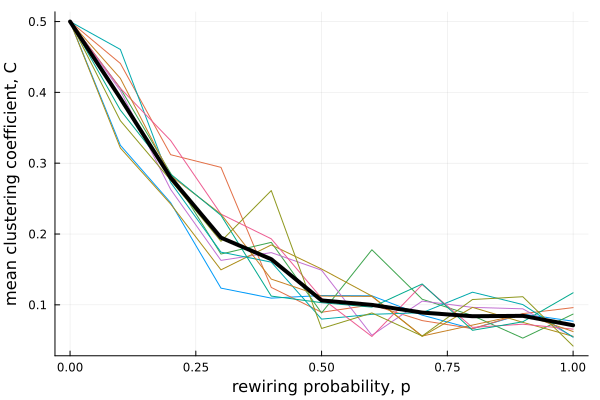

In [9]:
p_s = 0:0.1:1
trials = 10
L_s = fill(0.0, length(p_s), trials)
C_s = fill(0.0, length(p_s), trials)

for trial in 1:trials
    for i in 1:length(p_s)
        g = watts_strogatz(40, 4, p_s[i])
        # g = small_world(40, 4, p_s[i])
        L_s[i, trial] = average_shortest_path_length(g)
        C_s[i, trial] = global_clustering_coefficient(g)
    end
end

plot_lines(p_s, L_s, "mean shortest path length, L")
plot_lines(p_s, C_s, "mean clustering coefficient, C")

## Model 14

- ネットワーク上でのSIモデルを検証する。

In [10]:
function make_agents(N::Int, I_0::Int)::Vector{String}
    agents = fill("S", N)
    agents[1:I_0] .= "I"
    agents
end;

make_agents(10, 2)

10-element Vector{String}:
 "I"
 "I"
 "S"
 "S"
 "S"
 "S"
 "S"
 "S"
 "S"
 "S"

In [11]:
k <- 4
p <- 0.1
  
# create network for agent
g = watts_strogatz(N, k, p)

{40, 80} undirected simple Int64 graph

In [12]:
function contagion(;
    N::Int = 1000,    # population size
    k::Int = 4,       # degree
    p::Float64 = 0.0, # probability of rewiring
    n::Int = 1,
    I_0::Int = 2,     # initial "I" count
    generations::Int = 150,
    trials::Int = 10
)::Plots.Plot
    output = fill(0.0, generations, trials)

    for trial in 1:trials
        agents = make_agents(N, I_0)
        network = watts_strogatz(N, k, p)

        for generation in 1:generations
            focal_index_vec = shuffle(findall(==("S"), agents))
            
            for focal_index in focal_index_vec
                neighbours = neighbors(network, focal_index)

                if count(==("I"), agents[neighbours]) >= n
                    agents[focal_index] = "I"
                end
            end
            
            output[generation,trial] = count(==("I"), agents) / N
        end
    end
    
    p = plot(
        1:generations,
        output,
        ylim=(-0.05, 1.05),
        title="p = $p, n = $n",
        xlabel="generation",
        ylabel="proportion of Infected agents",
        titlefontsize=12,
        xguidefontsize=8,
        yguidefontsize=8,
        legend=false,
    )
    plot!(1:generations, mean(output, dims=2), lw=4, lc=:black)

    return p
end;

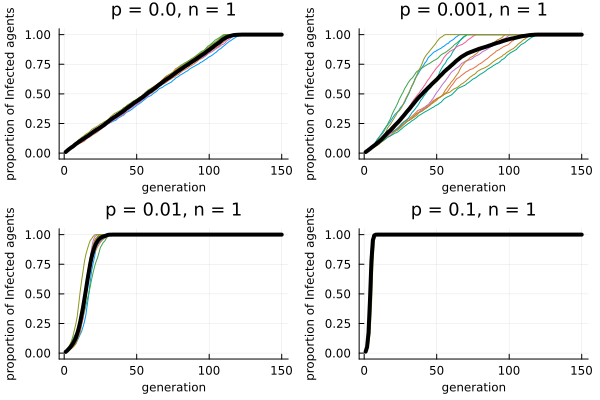

In [13]:
plot(
    contagion(p = 0.0),
    contagion(p = 0.001),
    contagion(p = 0.01),
    contagion(p = 0.1),
    layout=(2, 2)
)

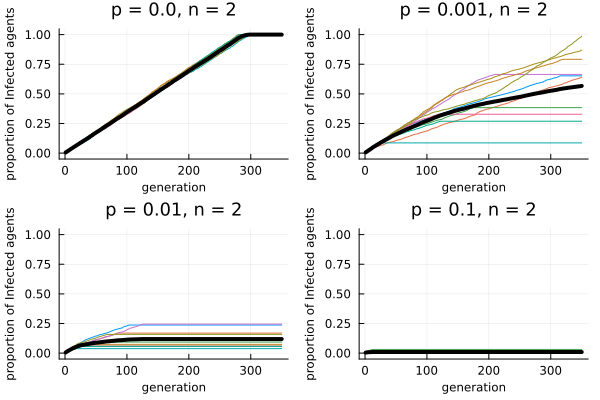

In [14]:
plot(
    contagion(generations = 350, n = 2, p = 0.0),
    contagion(generations = 350, n = 2, p = 0.001),
    contagion(generations = 350, n = 2, p = 0.01),
    contagion(generations = 350, n = 2, p = 0.1),
    layout=(2, 2)
)

- 平均距離 $L$ が短い方が感染が広がりやすくなる。
- 平均クラスタ係数 $C$ が高い方が感染が広がりやすくなる。
- $p$が増えると、$L$も$C$が下がる。
- $n$人以上の人と接触しないと感染しない。
- $n$が $1$ の場合は、$L$の変化の影響が強く出て、$C$の変化の影響はあまりない。
- $n$が $2$ 以上になると、$C$の変化の影響が強く出る。